#### The purpose of this EDA notebook is the following:
- Better understand the nature of the relationship between the independent variables
- Create an initial model with reasonable economic assumptions that may be dropped in later versions
- Explore methods of imputation for missing variables to provide more data samples
- Avoid linear combinations that might be more difficult to spot in the Bayesian Modeling process
- Establish a reasonable measure of variable importance, which along with correlation plots may inform initial hierarchies
- Create visualizations of poor quality data and also establish probability distributions for the likelihood function

#### 1. Import data and necessary packages

In [1]:
import os
# os.environ['KERAS_BACKEND'] = 'theano'
# os.environ['THEANO_FLAGS']='mode=FAST_RUN,device=cuda0,optimizer=fast_compile'

import pandas as pd
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')
from rfpimp import *
from rfpimp import plot_corr_heatmap
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from scipy.optimize import curve_fit
from scipy.stats import linregress
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import accuracy_score, mean_squared_error
from sklearn.preprocessing import StandardScaler
from multiprocessing import Pool
import importlib
from sklearn.inspection import permutation_importance
# import category_encoders as ce
# from catboost import CatBoostRegressor, Pool
import arviz as az
import pymc3 as pm
import theano
import bambi as bmb
import theano.tensor as tt
from sklearn import preprocessing
# import shap
import mkl
from statsmodels.stats.outliers_influence import variance_inflation_factor
from fitter import Fitter, get_common_distributions, get_distributions
import xarray
from sklearn.metrics import mean_squared_error
from pymc3.variational.callbacks import CheckParametersConvergence


# %load_ext timeit
# %load_ext heat
# %load_ext line_profiler
# %load_ext memory_profiler

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Could not locate executable g77
Could not locate executable f77
Could not locate executable ifort
Could not locate executable ifl
Could not locate executable f90
Could not locate executable DF
Could not locate executable efl


In [2]:
df = pd.read_csv('G:/My Drive/IN/Data/Robyn/dt_simulated_weekly.csv')
df_bu = df
df.describe()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 208 entries, 0 to 207
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   DATE                208 non-null    object 
 1   revenue             208 non-null    float64
 2   tv_S                208 non-null    float64
 3   ooh_S               208 non-null    int64  
 4   print_S             208 non-null    float64
 5   facebook_I          208 non-null    float64
 6   search_clicks_P     208 non-null    float64
 7   search_S            208 non-null    int64  
 8   competitor_sales_B  208 non-null    int64  
 9   facebook_S          208 non-null    float64
 10  events              208 non-null    object 
 11  newsletter          208 non-null    float64
dtypes: float64(7), int64(3), object(2)
memory usage: 19.6+ KB


Pandas dataframes will have string, int, and float columns. The following
three sections will look for columns that need to be fixed or ped altogether

##### The following few sections analyze categorical, float, and int variables
##### so the dataset can be cleaned

In [4]:
# df = df.drop(['Program Name', 'Retailers', 'Tactic', 'Vendor', 'Tactic Start Date',
#               'Tactic End Date'], axis=1)
segment = [var for var in df.columns if df[var].dtype == 'O']
print('There are {} categorical variables\n'.format(len(segment)))
print('The categorical variables are :\n\n', segment)
print(df[segment].isnull().sum() / len(df))
df_cat = df.select_dtypes(include=object)
df_cat.info()
df_cat.describe()
print(df_cat.nunique())

There are 2 categorical variables

The categorical variables are :

 ['DATE', 'events']
DATE      0.0
events    0.0
dtype: float64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 208 entries, 0 to 207
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   DATE    208 non-null    object
 1   events  208 non-null    object
dtypes: object(2)
memory usage: 3.4+ KB
DATE      208
events      3
dtype: int64


In [5]:
# df.RMN.replace(('Yes', 'No'), (1, 0), inplace=True)

AttributeError: 'DataFrame' object has no attribute 'RMN'

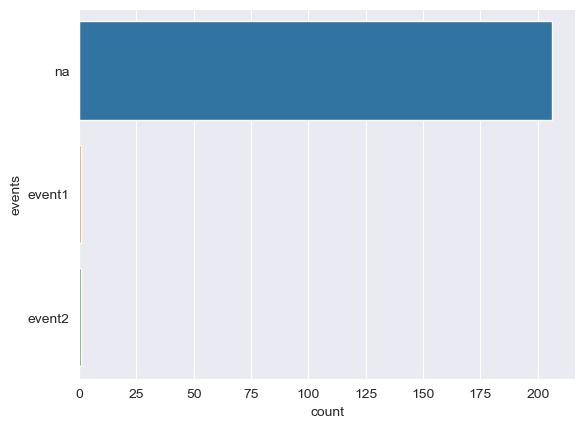

In [6]:
for col in df.select_dtypes(include='object'):
    if df[col].nunique() <= 25:
        sns.countplot(y=col, data=df)
        plt.show()

In [7]:
# df = df.drop(
#     [], axis=1)
integer = [var for var in df.columns if df[var].dtype == 'int64']
print('There are {} integer variables\n'.format(len(integer)))
print('The integer variables are :\n\n', integer)
print(df[integer].isnull().sum())
df_int = df.select_dtypes(include=int)
if len(df_int.columns) > 0.0:
    df_int.info()
    df_int.describe()

There are 3 integer variables

The integer variables are :

 ['ooh_S', 'search_S', 'competitor_sales_B']
ooh_S                 0
search_S              0
competitor_sales_B    0
dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 208 entries, 0 to 207
Data columns (total 3 columns):
 #   Column              Non-Null Count  Dtype
---  ------              --------------  -----
 0   ooh_S               208 non-null    int64
 1   search_S            208 non-null    int64
 2   competitor_sales_B  208 non-null    int64
dtypes: int64(3)
memory usage: 5.0 KB


##### In the below section we address the large number of missing s and also
##### the columns consisting entirely of zeroes, and drop them accordingly

In [8]:
# df = df.drop(
#         ['Base $', 'Incr $', 'Base Units', 'Incr Units',
#          '$ Shr - Ty Subcategory', 'Units Shr - Ty Category',
#          'Units Shr - Ty Subcategory'], axis=1)
fp = [var for var in df.columns if df[var].dtype == 'float64']
print('There are {} float variables\n'.format(len(fp)))
print('The float variables are :\n\n', fp)
fp_na = df[fp].isnull().sum() / len(df) * 100
print(fp_na[fp_na > 10])
fp_zero = df[fp].sum()
print(fp_zero[fp_zero == 0.0])

There are 7 float variables

The float variables are :

 ['revenue', 'tv_S', 'print_S', 'facebook_I', 'search_clicks_P', 'facebook_S', 'newsletter']
Series([], dtype: float64)
Series([], dtype: float64)


In [10]:
# df = df.drop(
#         ['ClientId', 'Program Id', 'TacticId', 'CategoryId',
#          'BrandId', 'Nielsen_Week_Year', 'VendorId'], axis=1)
df_num = df.select_dtypes(exclude='object')
df_num.describe()

,revenue,tv_S,ooh_S,print_S,facebook_I,search_clicks_P,search_S,competitor_sales_B,facebook_S,newsletter
count,2.080000e+02,2.080000e+02,208.000000,208.000000,2.080000e+02,208.000000,208.000000,2.080000e+02,208.000000,208.000000
mean,1.822143e+06,1.113277e+05,81033.639423,27964.741987,2.446024e+07,50835.620540,44366.346154,5.538025e+06,64369.734788,22386.523669
std,7.162286e+05,2.141877e+05,157483.924979,48623.026739,3.509738e+07,40842.281019,35268.769589,2.077192e+06,94810.914099,19104.164424
min,6.722500e+05,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000,0.000000,2.240235e+06,0.000000,301.000000
25%,1.165211e+06,0.000000e+00,0.000000,0.000000,0.000000e+00,18842.053510,17650.000000,3.589581e+06,0.000000,9010.500000
50%,1.874514e+06,0.000000e+00,0.000000,0.000000,0.000000e+00,42795.757485,36050.000000,5.538524e+06,0.000000,19401.653850
75%,2.378407e+06,1.380503e+05,95359.000000,35758.750002,4.121226e+07,75710.530683,64025.000000,7.311814e+06,108690.367000,27546.500000
max,3.827520e+06,1.185349e+06,938178.000000,239417.333300,1.782983e+08,156564.384600,134100.000000,9.984742e+06,462011.742200,96236.000000


The following heat maps are obviously important for understanding relationships,
but more importantly their dataframes provide the ability to fill df.colnames
that will be key to making a decision on what variables to explore for feature importance

,revenue,tv_S,ooh_S,print_S,facebook_I,search_clicks_P,search_S,competitor_sales_B,facebook_S,newsletter
count,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000
mean,0.463000,0.249000,0.110000,0.219000,0.317000,0.347000,0.352000,0.457000,0.315000,0.307000
std,0.283041,0.281601,0.324243,0.283567,0.393335,0.386467,0.385452,0.288523,0.394919,0.307392
min,0.100000,0.030000,-0.100000,0.030000,-0.090000,-0.010000,-0.010000,0.110000,-0.100000,-0.080000
25%,0.380000,0.132500,-0.062500,0.095000,0.027500,0.020000,0.027500,0.297500,0.027500,0.102500
50%,0.400000,0.150000,0.015000,0.150000,0.180000,0.265000,0.275000,0.400000,0.175000,0.260000
75%,0.407500,0.245000,0.107500,0.205000,0.395000,0.442500,0.447500,0.437500,0.395000,0.445000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


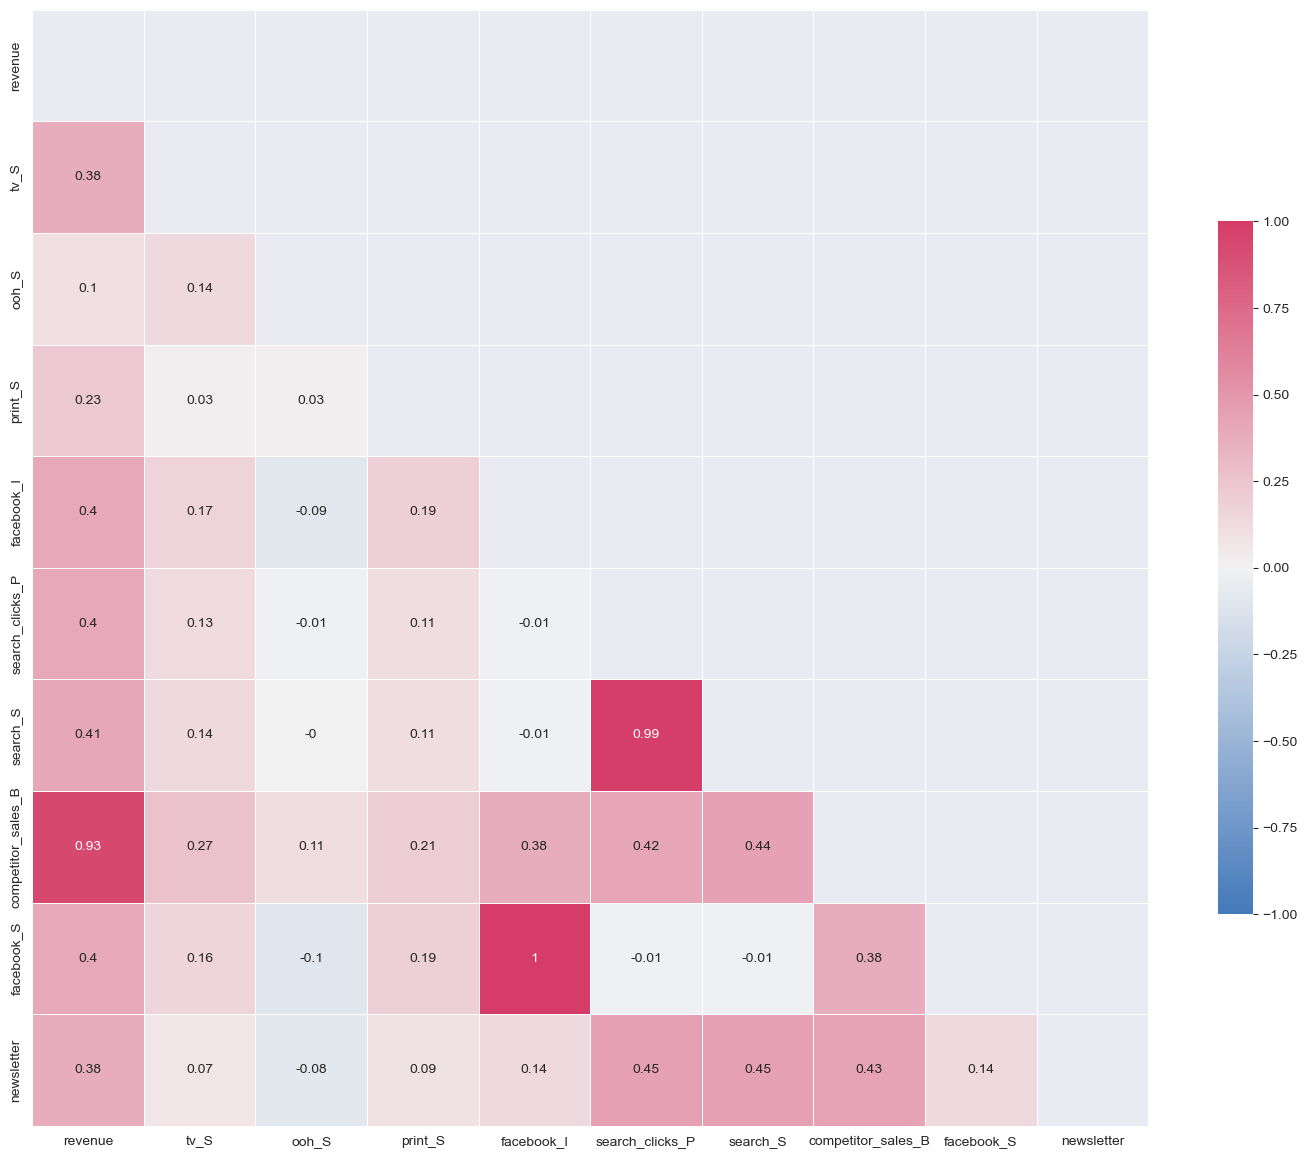

In [11]:
corr = df_num.corr(method="spearman").round(2)
mask = np.triu(np.ones_like(corr, dtype=bool))
f, ax = plt.subplots(figsize=(18, 18))
cmap = sns.diverging_palette(250, 1, as_cmap=True)
sns.heatmap(corr, annot=True, mask=mask, cmap=cmap, vmax=1, vmin=-1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
corr.describe()

Here we use the correlation df and filter by a minimum threshold, while
eliminating one to avoid including the variable itself
by converting it to a list, we can use it in our feature importance plots

              feature        VIF
0             revenue  56.250554
1                tv_S   1.606721
2               ooh_S   1.368295
3             print_S   1.479460
4          facebook_I  88.970204
5     search_clicks_P  79.092444
6            search_S  82.042605
7  competitor_sales_B  53.776913
8          facebook_S  87.717266
9          newsletter   4.000510


,revenue,tv_S,ooh_S,print_S,facebook_I,search_clicks_P,search_S,competitor_sales_B,facebook_S,newsletter
count,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000
mean,0.463000,0.249000,0.110000,0.219000,0.317000,0.347000,0.352000,0.457000,0.315000,0.307000
std,0.283041,0.281601,0.324243,0.283567,0.393335,0.386467,0.385452,0.288523,0.394919,0.307392
min,0.100000,0.030000,-0.100000,0.030000,-0.090000,-0.010000,-0.010000,0.110000,-0.100000,-0.080000
25%,0.380000,0.132500,-0.062500,0.095000,0.027500,0.020000,0.027500,0.297500,0.027500,0.102500
50%,0.400000,0.150000,0.015000,0.150000,0.180000,0.265000,0.275000,0.400000,0.175000,0.260000
75%,0.407500,0.245000,0.107500,0.205000,0.395000,0.442500,0.447500,0.437500,0.395000,0.445000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


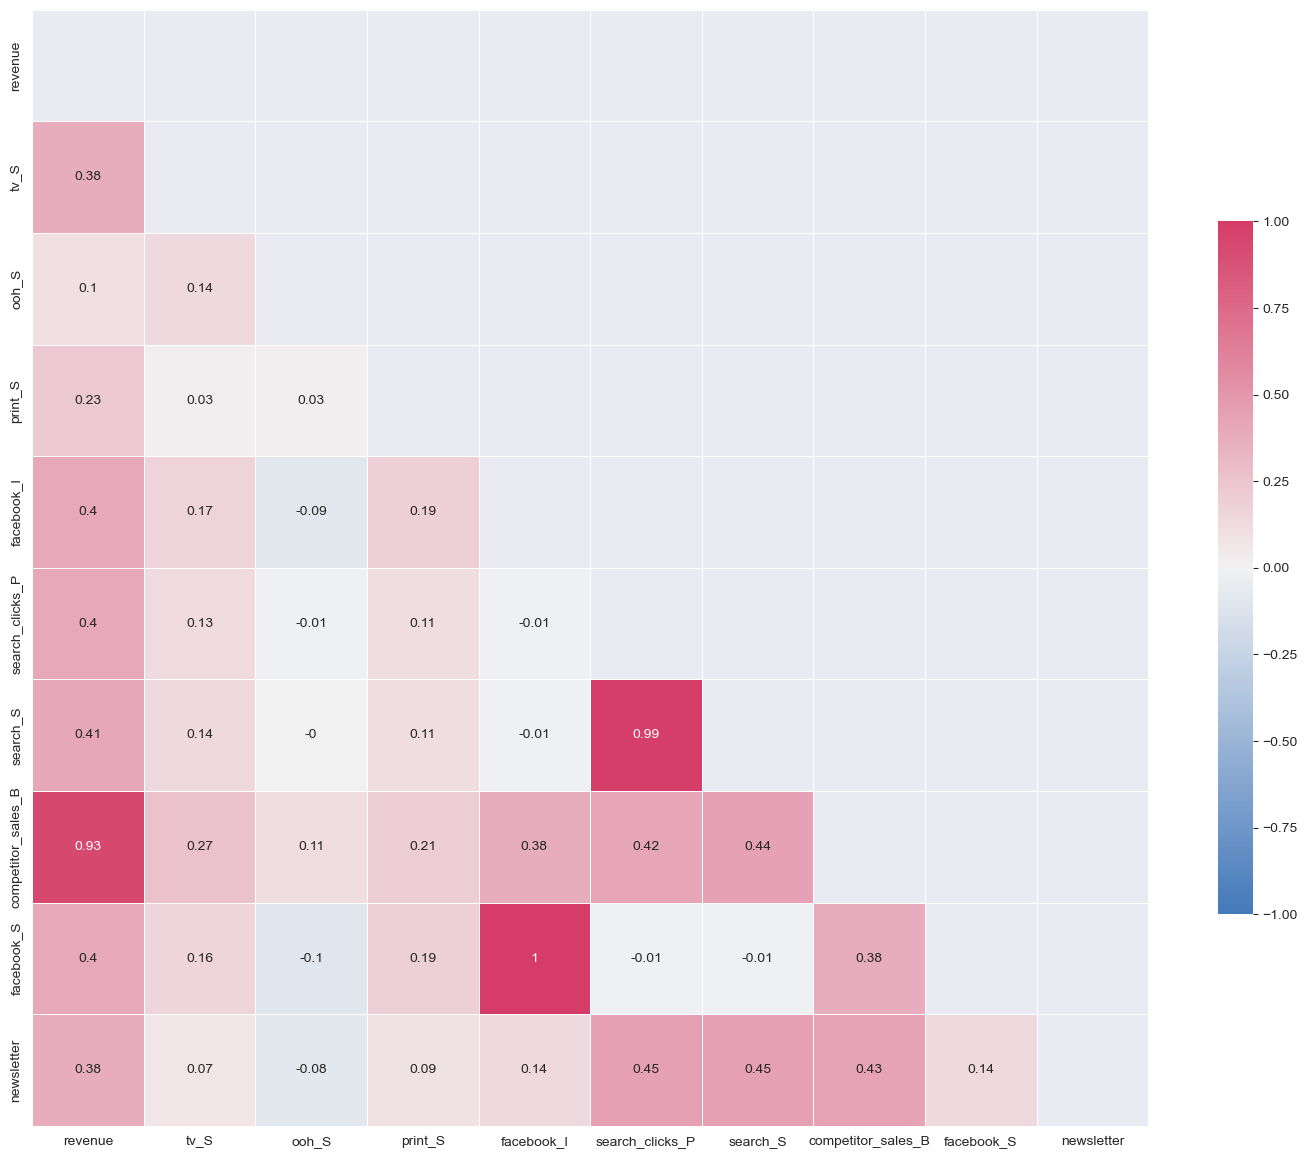

In [12]:
# use VIF along with variable importance to check new dataframes
vif_df = df_num[~df_num.isin([np.nan, np.inf, -np.inf]).any(1)]

X = vif_df
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(len(X.columns))]
print(vif_data)

corr_vif = vif_df.corr(method="spearman").round(2)
mask = np.triu(np.ones_like(corr_vif, dtype=bool))
plt.subplots(figsize=(18, 18))
cmap = sns.diverging_palette(250, 1, as_cmap=True)
sns.heatmap(corr, annot=True, mask=mask, cmap=cmap, vmax=1, vmin=-1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
corr_vif.describe()

In [13]:
# df_num = df_num.drop(['Units', 'Impressions per Week',
#                       'Any Promo %ACV', '%ACV Distribution'], axis=1)
corr = df_num.corr(method="spearman").round(2)

In [14]:
def imp_plots(target, predictors):
    """Form three importance plots

    :param target:'dependent' component
    :param predictors:'predictive' component
    """
    target = target
    df_all = df_num.dropna().astype(dtype='int32')
    df_all = df_all[predictors + [target]]
    df_train, df_test = train_test_split(df_all, test_size=0.15)
    X_train, y_train = df_train.drop(target, axis=1), df_train[target]
    X_test, y_test = df_test.drop(target, axis=1), df_test[target]
    rf = RandomForestClassifier(n_estimators=100, n_jobs=-1,
                                max_features=1.0,
                                min_samples_leaf=10, oob_score=True)
    rf.fit(X_train, y_train)
    RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                           max_depth=None, max_features=1.0, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_samples_leaf=10,
                           min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
                           oob_score=True, random_state=None, verbose=0, warm_start=False)
    figure, (ax1, ax2, ax3) = plt.subplots(nrows=3, ncols=1, figsize=(10, 10))
    imp1 = importances(rf, X_test, y_test)
    plot_importances(imp1, width=16, vscale=4, ax=ax1)

    imp = pd.DataFrame()
    imp['Feature'] = X_train.columns
    imp['Importance'] = rf.feature_importances_
    imp = imp.sort_values('Importance', ascending=False)
    imp2 = imp.set_index('Feature')
    plot_importances(imp2, width=16, vscale=4, ax=ax2)

    perm_importance = permutation_importance(rf, X_test, y_test)
    perm = pd.DataFrame()
    perm['Feature'] = X_test.columns
    perm['Importance'] = perm_importance.importances_mean
    perm = perm.sort_values('Importance', ascending=False)
    perm = perm.set_index('Feature')
    plot_importances(perm, width=16, vscale=4, ax=ax3)
    a = imp1.sort_values(by='Feature')
    b = imp2.sort_values(by='Feature')
    c = perm.sort_values(by='Feature')
    d = (np.abs(a) + np.abs(b) + np.abs(c)).sort_values('Importance',
                                                        ascending=False).mean(axis=1)
    plt.show()
    return d

The following three importance plots look at different ways to measure importance
in relation to predicting our variable of interest. We can continue this
process many times to develop our Bayesian Hierarchy

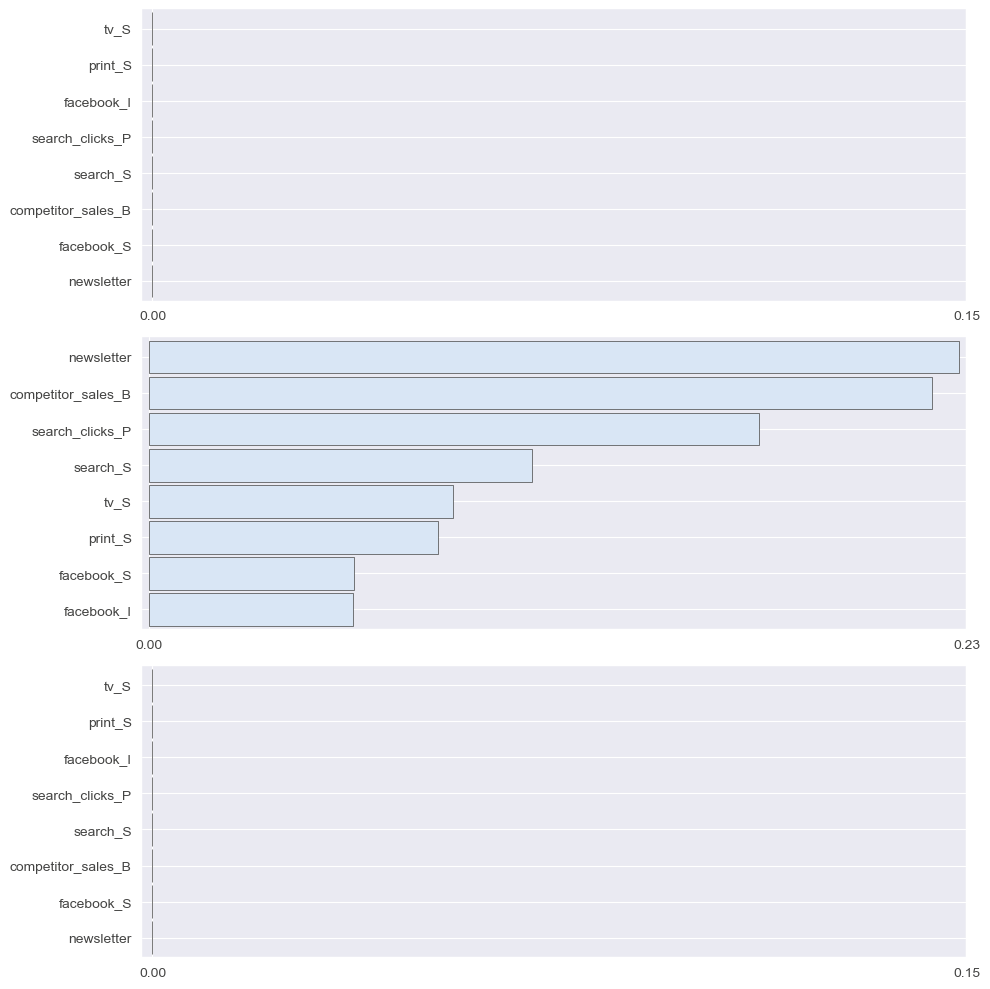

Feature
newsletter            0.225730
competitor_sales_B    0.218146
search_clicks_P       0.169832
search_S              0.106703
tv_S                  0.084845
print_S               0.080577
facebook_S            0.057234
facebook_I            0.056933
dtype: float64


In [17]:
corr_imp = corr[abs(corr['revenue'] > .20) & (corr['revenue'] < 1.0)]
corr_imp = corr_imp[['revenue']]
features = corr_imp.index.tolist()
imp_sales = imp_plots('revenue', features)
print(imp_sales)

In [ ]:
# corr_imp = corr[abs(corr['Number of UPCs Selling'] > .20) & (corr['Number of UPCs Selling'] < 1.0)]
# corr_imp = corr_imp[['Number of UPCs Selling']]
# features = corr_imp.index.tolist()
# imp_UPC = imp_plots('Number of UPCs Selling', features)
# print(imp_UPC)

In [18]:
corr_imp = corr[
    abs(corr['Price Decr Only %ACV'] > .20) & (corr['Price Decr Only %ACV'] < 1.0)]
corr_imp = corr_imp[['Price Decr Only %ACV']]
features = corr_imp.index.tolist()
imp_price_decr = imp_plots('Price Decr Only %ACV', features)
print(imp_price_decr)

KeyError: 'Price Decr Only %ACV'

In [ ]:
corr_imp = corr[abs(corr['Any Promo Units'] > .20) & (corr['Any Promo Units'] < 1.0)]
corr_imp = corr_imp[['Any Promo Units']]
features = corr_imp.index.tolist()
imp_promo_unit = imp_plots('Any Promo Units', features)
print(imp_promo_unit)

In [ ]:
corr_imp = corr[
    abs(corr['Feat w/o Disp %ACV'] > .20) & (corr['Feat w/o Disp %ACV'] < 1.0)]
corr_imp = corr_imp[['Feat w/o Disp %ACV']]
features = corr_imp.index.tolist()
imp_feat_no_disp = imp_plots('Feat w/o Disp %ACV', features)
print(imp_feat_no_disp)

This can be repeated for every variable of interest in the hierarchy
The below kde plots are crucial to understanding the likelihood function
distribution and beginning the Bayesian modeling

#### 2. This section continues on to modeling and exploration of modeling techniques

In [ ]:
final_vars_cat = ['Any Promo Units', '%ACV Distribution',
                  'Feat w/o Disp %ACV', 'Price Decr Only %ACV', 'Disp w/o Feat %ACV',
                  'Total Sales', 'Feat & Disp %ACV', 'RMN', 'Tactic Category', 'Brand']

final_vars = ['Any Promo Units', '%ACV Distribution',
              'Feat w/o Disp %ACV', 'Price Decr Only %ACV', 'Disp w/o Feat %ACV',
              'Total Sales', 'Feat & Disp %ACV', 'RMN']

In [ ]:
df_final = df[final_vars]

dist_list = ['gamma', 'expon', 'cauchy', 'norm', 'uniform']

for var in final_vars:
    dist_test = df_final[var].dropna()
    dist_test = dist_test.values
    f = Fitter(dist_test, distributions=dist_list, timeout=60)
    f.fit()
    print(var)
    print(f.summary(plot=False))
    print(f.get_best(method='sumsquare_error'))

##### 2.1 Here I tested the Bambi package to establish a baseline,
##### but it slows down the modeling process

In [ ]:
df_nostr = df[final_vars]
df_nostr = df_nostr[df_nostr['Total Sales'] > 0.0]
df_nostr.columns = df_nostr.columns.str.replace('[#,@,&,%,''//''," "]', '')

df_nostr['TotalSales'] = np.log(df_nostr['TotalSales'])

In [ ]:
bmb_model = bmb.Model('TotalSales ~ '
                      ' FeatwoDispACV + PriceDecrOnlyACV + DispwoFeatACV'
                      , data=df_nostr, dropna=False)

bmb_fitted = bmb_model.fit(draws=3000, tune=3000, chains=4)

##### 2.3 Here I test and get diagnostics for this model
##### and to prepare for the more complicated model

In [ ]:
az.plot_trace(bmb_fitted)
print(az.summary(bmb_fitted))
print(az.ess(bmb_fitted))
az.plot_posterior(bmb_fitted, hdi_prob=0.99)
az.plot_energy(bmb_fitted);

##### 2.4 Note the above graph and compare it to the
##### graph at the end. Having each chain closer to one
##### is the ideal

In [ ]:
df_final_cat = df_bu[final_vars_cat]
df_final_cat = df_final_cat[df_final_cat['Total Sales'] > 0.0]

The following two charts show that many Tactic Category observations have dropped and two categories have also dropped.

In [ ]:
for col in df.select_dtypes(include='object'):
    if df[col].nunique() <= 25:
        sns.countplot(y=col, data=df)
        plt.show()

print('Original number of obs and Tactic Categories')
print(df['Tactic Category'].count())
print(df['Tactic Category'].nunique())

In [ ]:
for col in df_final_cat.select_dtypes(include='object'):
    if df_final_cat[col].nunique() <= 25:
        sns.countplot(y=col, data=df_final_cat)
        plt.show()

print('Number of obs, new tactics, and new displays')
print(df_final_cat['Tactic Category'].count())
print(df_final_cat['Tactic Category'].nunique())
print(df_final_cat['Brand'].nunique())

In [ ]:
tt.config.floatX = 'float64'

df_final_cat = df_bu[final_vars_cat]
df_final_cat = df_final_cat[df_final_cat['Total Sales'] > 0.0]

df_final_cat['Total Sales'] = np.log(df_final_cat['Total Sales'])

price_decr_idxs, price_decr = pd.factorize(df_final_cat['Price Decr Only %ACV'],
                                           sort=True)
tactic_idxs, tactics = pd.factorize(df_final_cat['Tactic Category'], sort=True)
brand_idxs, brand = pd.factorize(df_final_cat['Brand'], sort=True)
coords = {"tactics": tactics, 'brand': brand, 'obs_idx': np.arange(len(tactic_idxs)), 'price_decrease': price_decr}

#### 3. Hierarchical Model with diagnostics

In [ ]:
with pm.Model(coords=coords) as h_model:
    tactic_idx = pm.Data("Tactic Category", tactic_idxs, dims="obs_idx")
    brand_idx = pm.Data("Brand", brand_idxs, dims="obs_idx")
    price_decr = pm.Data("Price Decrease Only", price_decr_idxs, dims="obs_idx")

    # Tactic Category hyperpriors parameters:
    hp_b_0 = pm.Normal("hp_b_0", mu=0.0, sigma=5.0)
    sigma_a = pm.Exponential("sigma_a", 1.0)
    hp_b_1 = pm.Normal("hp_b_1", mu=0.0, sigma=1.0)
    sigma_b = pm.Exponential("sigma_b", 0.5)

    # Brand hyperpriors parameters
    hp_b_2 = pm.Normal("hp_b_2", mu=0.0, sigma=5.0)
    sigma_c = pm.Exponential("sigma_c", 1.0)
    hp_b_3 = pm.Normal("hp_b_3", mu=0.0, sigma=1.0)
    sigma_d = pm.Exponential("sigma_d", 0.5)

    hp_b_4 = pm.Normal("hp_b_4", mu=0.5, sigma=.3)

    # estimates of independent intercepts and interactions of intercepts
    b_0 = pm.Normal("tactic_int", mu=hp_b_0, sigma=sigma_a, dims="tactics")
    b_1 = pm.Normal("tactic_slope", mu=hp_b_1, sigma=sigma_b, dims="tactics")

    b_2 = pm.Normal("display_int", mu=hp_b_2, sigma=sigma_c, dims="brand")
    b_3 = pm.Normal("display_slope", mu=hp_b_3, sigma=sigma_d, dims="brand")

    price_decr_est = hp_b_4 * price_decr

    # estimate of total sales using intercepts
    sales_est_1 = b_0[tactic_idx] + b_1[tactic_idx] * brand_idx
    sales_est_2 = b_2[brand_idx] + b_3[brand_idx] * tactic_idx
    sales_est = sales_est_1 + sales_est_2 + price_decr_est

    # Data likelihood
    epsilon = pm.Exponential("noise", 1.0)
    Total_Sales = pm.Normal(
            "Log_Total_Sales", mu=sales_est, sigma=epsilon,
            observed=df_final_cat['Total Sales'], dims="obs_idx")

with h_model:
    h_trace = pm.sample(draws=3000, init='advi+adapt_diag', chains=4,
                                   cores=4, tune=3000,
                                   target_accept=0.8, return_inferencedata=True)

In [ ]:
with h_model:
    model_ppc = pm.sample_posterior_predictive(
            h_trace, h_model)

In [ ]:
print('Model R-Squared')
print(az.r2_score(df_final_cat['Total Sales'].values, model_ppc['Log_Total_Sales']))
def score_model(trace,y,model_name):
    """

    :param trace: trace from PyMC3 plot
    :param y: samples
    :param model_name: model from PyMC3
    """
    post_ppc = pm.sample_posterior_predictive(trace, samples=20841,
                                         model=model_name)
    pred = post_ppc['Log_Total_Sales'].mean(axis=0)
    mse = np.sqrt(mean_squared_error(y, pred))
    print('The Mean Squared Error')
    print(mse)

score_model(h_trace, df_final_cat['Total Sales'], h_model)

print('Trace Summary and Effective Sample Size')
print(az.summary(h_trace, kind='stats'))
print(az.summary(h_trace, kind='diagnostics'))
az.plot_posterior(h_trace, hdi_prob=0.99)
az.plot_energy(h_trace)
plt.show()
print('Bayesian fraction of missing information')
print(az.bfmi(h_trace))
az.plot_forest(h_trace, kind='ridgeplot')

In [ ]:
pm.model_to_graphviz(h_model)

In [ ]:
h_trace.to_csv(index=False)